Attention을 이용한 word기반 ASR

In [ ]:
# [1] 필수 라이브러리 설치 및 데이터 다운로드
!pip install librosa tensorflow scikit-learn soundfile --quiet

!mkdir -p recordings
!wget -q https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip
!unzip -q master.zip "free-spoken-digit-dataset-master/recordings/*" -d .
!mv free-spoken-digit-dataset-master/recordings/* recordings/
!rm -rf free-spoken-digit-dataset-master master.zip

In [ ]:
# [2] 전체 모델 구현 및 학습 코드

import os
import librosa
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# 1. 데이터 로드 및 Mel-Spectrogram 추출
file_paths = sorted(glob("recordings/*.wav"))

def extract_mel_features(file_list, sr=16000, n_mels=80):
    X, y = [], []
    for path in file_list:
        label = os.path.basename(path)[0]
        waveform, _ = librosa.load(path, sr=sr)
        mel = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = librosa.util.normalize(mel_db).T  # 정규화 + 전치
        X.append(mel_db)
        y.append(label)
    return X, y

X, y = extract_mel_features(file_paths)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 시퀀스 길이 패딩
maxlen = max([x.shape[0] for x in X])
X_pad = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=maxlen, padding='post', dtype='float32')

# 학습/검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)

# 2. Positional Encoding 레이어 정의
class PositionalEncoding(tf.keras.layers.Layer):
    def call(self, x):
        seq_len = tf.shape(x)[1]
        d_model = tf.shape(x)[2]

        pos = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)     # [T, 1]
        i = tf.cast(tf.range(d_model)[tf.newaxis, :], tf.float32)       # [1, D]

        angle_rates = 1 / tf.pow(10000., (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        angle_rads = pos * angle_rates

        angle_rads = tf.where(i % 2 == 0, tf.cos(angle_rads), tf.sin(angle_rads))  # [T, D]
        return x + angle_rads[tf.newaxis, :, :]  # [1, T, D] broadcasting

# 3. 모델 정의 함수 (Conv1D + Attention + Dense 구조)
def build_model(input_shape, num_classes):
    # 입력층: 입력 shape은 (time_steps, 80), 여기서 80은 Mel feature의 개수
    inputs = tf.keras.Input(shape=input_shape)  # [T, 80]

    # 1단계: Conv1D로 지역적인 시간 패턴 추출 (예: 자음, 모음의 경계)
    # 필터 수 128개, 커널 크기 5, ReLU 활성화
    x = tf.keras.layers.Conv1D(
        filters=128, #128로 한 이유는 mel filter 수 80개를 커버치고 2의 거듭제곱을 맞추기 위해서이다.
        kernel_size=5,
        padding='same',
        activation='relu'
    )(inputs)  # 출력 shape: [T, 128]

    # 2단계: Batch Normalization으로 학습 안정화 및 수렴 속도 향상
    x = tf.keras.layers.BatchNormalization()(x)  # 출력 shape: [T, 128]

    # 3단계: Dense 레이어를 통해 차원 조정 (다음 단계에서 position encoding 적용하기 위함)
    # Conv1D의 출력 128차원을 그대로 유지하되, 이 레이어가 학습 가능한 임베딩 역할을 수행
    x = tf.keras.layers.Dense(128)(x)  # 출력 shape: [T, 128]

    # 4단계: Positional Encoding 추가 (Transformer 구조에서 필수)
    # 입력 시퀀스에 순서 정보를 더해줌 (위치 정보가 없으면 self-attention은 순서를 인식 못함)
    x = PositionalEncoding()(x)  # 출력 shape: [T, 128]

    # 5단계: Multi-Head Self-Attention
    # 각 프레임이 전체 프레임을 참고하여 문맥 정보를 반영하도록 함
    # num_heads=2 → 독립된 주의집중 기법을 2개 동시에 수행
    x = tf.keras.layers.MultiHeadAttention(
        num_heads=2,
        key_dim=64  # head당 차원 = 64 → 전체 임베딩 차원 128 유지
    )(x, x)  # 출력 shape: [T, 128]

    # 6단계: 시퀀스 전체를 하나의 벡터로 요약 (시간 차원 평균)
    # 예: 여러 프레임의 정보를 통합하여 전체 발화를 요약함
    x = tf.keras.layers.GlobalAveragePooling1D()(x)  # 출력 shape: [128]
    #위는 평균값을 대표값으로 쓰겠다는 뜻이다.

    # 7단계: Dense 레이어로 비선형 특징 추출 (중간 표현 강화)
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # 출력 shape: [128]

    # 8단계: 과적합 방지를 위한 Dropout (30% 확률로 뉴런 비활성화)
    x = tf.keras.layers.Dropout(0.3)(x)

    # 9단계: 최종 출력층 (softmax) → 숫자 0~9 분류
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  # 출력 shape: [10]

    # 모델 구성
    return tf.keras.Model(inputs, outputs)


model = build_model(input_shape=(maxlen, 80), num_classes=10)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# [3] 모델 학습 (EarlyStopping 적용)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop]
)

# [4] 추론 함수 정의 및 테스트
def predict_digit(path):
    waveform, _ = librosa.load(path, sr=16000)
    mel = librosa.feature.melspectrogram(y=waveform, sr=16000, n_mels=80)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = librosa.util.normalize(mel_db).T
    mel_pad = tf.keras.preprocessing.sequence.pad_sequences([mel_db], maxlen=maxlen, padding='post', dtype='float32')
    pred = model.predict(mel_pad, verbose=0).argmax(axis=1)[0]
    return label_encoder.inverse_transform([pred])[0]

# 예시 테스트
test_file = file_paths[0]
print("파일:", test_file)
print("예측 결과:", predict_digit(test_file))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 72, 80)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 72, 128)   │     51,328 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 72, 128)   │     16,512 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 72, 128)   │          0 │ dense_6[0][0]     │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 72, 128)   │     66,048 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10)        │      1,290 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 152,202 (594.54 KB)

 Trainable params: 151,946 (593.54 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.2895 - loss: 1.8428 - val_accuracy: 0.1917 - val_loss: 2.3856
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6762 - loss: 0.8181 - val_accuracy: 0.7617 - val_loss: 0.6904
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7883 - loss: 0.5588 - val_accuracy: 0.6900 - val_loss: 0.8116
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8432 - loss: 0.4295 - val_accuracy: 0.7883 - val_loss: 0.5318
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8404 - loss: 0.4175 - val_accuracy: 0.7483 - val_loss: 0.7032
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8939 - loss: 0.2884 - val_accuracy: 0.8583 - val_loss: 0.4443
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9114 - loss: 0.2552 - val_accuracy: 0.3300 - val_loss: 3.3505
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8867 - loss: 0.2982 - val_acc

In [ ]:
for i in range(10):
  test_file=file_paths[200+i]
  print("파일: ", test_file)
  print("예측 결과: ", predict_digit(test_file))

파일:  recordings/0_theo_0.wav
예측 결과:  0
파일:  recordings/0_theo_1.wav
예측 결과:  0
파일:  recordings/0_theo_10.wav
예측 결과:  0
파일:  recordings/0_theo_11.wav
예측 결과:  0
파일:  recordings/0_theo_12.wav
예측 결과:  0
파일:  recordings/0_theo_13.wav
예측 결과:  0
파일:  recordings/0_theo_14.wav
예측 결과:  0
파일:  recordings/0_theo_15.wav
예측 결과:  0
파일:  recordings/0_theo_16.wav
예측 결과:  0
파일:  recordings/0_theo_17.wav
예측 결과:  0


In [ ]:
def build_model(input_shape, num_classes):
    # 입력층: 입력의 모향은 (T, 80)이다. T는 text의 길이이고, 80은 mel filter bank의 갯수이다.
    inputs = tf.keras.Input(shape=input_shape)  # [T, 80]
    # 1단계:	convolution연산을 하는데, filter의 개수는 128로 한다.
    #왜냐, mel filter bank 80개를 다 커버 칠 수 있는 2의 거듭제곱값은 128이므로,
    #그리고 이 filter와 convolution하는 kernel mask의 크기는 5*5이다. active function으로는 relu함수를 사용한다.
    x = tf.keras.layers.Conv1D(
        filters=128,
        kernel_size=5,
        padding='same',
        activation='relu'
    )(inputs)  # 출력 shape: [T, 128]
    # 2단계: layer를 지나면서 weight를 계속 곱해지는데, 그러면 layer를 지날 수록 값이 너무 커진다. 그래서 정규화 과정을 통해 값의 크기를 제한하는 것이다.
    x = tf.keras.layers.BatchNormalization()(x)  # 출력 shape: [T, 128]
    # 3단계: fully connected layer, dence layer를 통해 차원을 조절하여, 다음 단계에서 position embedding를 적용할 수 있도록 한다.
    x = tf.keras.layers.Dense(128)(x)  # 출력 shape: [T, 128]
    # 4단계:
    x = PositionalEncoding()(x)  # 출력 shape: [T, 128]
    # 5단계: 각 frame이 전체 frame을 확인하여 문맥 정보를 파악해 자신의 문자를 유추
    x = tf.keras.layers.MultiHeadAttention(
        num_heads=2,
        key_dim=64
    )(x, x)
    # 6단계: 평균값을 대표값으로 정한다.
    x = tf.keras.layers.GlobalAveragePooling1D()(x)  # 출력 shape: [128]
    # 7단계: 비선형 특징 추출
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # 출력 shape: [128]
    # 8단계: 과적합을 방지하기 위해 layer 사이 임의의 node끼리의 연결을 끊음
    x = tf.keras.layers.Dropout(0.3)(x)
    # 9단계: 최종 출력으로 0~9숫자로 분류한다.
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    # 모델 구성
    return tf.keras.Model(inputs, outputs)

Deeply Korean read speech corpus라는 데이터 셋으로 모델을 학습해보자

In [ ]:
# 1. 데이터 다운로드
!wget -O KoreanReadSpeechCorpus.tar.gz https://www.openslr.org/resources/97/KoreanReadSpeechCorpus.tar.gz

# 2. 압축 해제
!tar -xvzf KoreanReadSpeechCorpus.tar.gz

--2025-07-16 12:25:28--  https://www.openslr.org/resources/97/KoreanReadSpeechCorpus.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://openslr.elda.org/resources/97/KoreanReadSpeechCorpus.tar.gz [following]
--2025-07-16 12:25:29--  https://openslr.elda.org/resources/97/KoreanReadSpeechCorpus.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 281297310 (268M) [application/x-gzip]
Saving to: ‘KoreanReadSpeechCorpus.tar.gz’

KoreanReadSpeechCor 100%[===================>] 268.27M  19.8MB/s    in 15s     

2025-07-16 12:25:45 (18.0 MB/s) - ‘KoreanReadSpeechCorpus.tar.gz’ saved [281297310/281297310]

AirbnbStudio/
AirbnbStudio/sub100100a00000.wav
Air

In [ ]:
import json
import pandas as pd

# JSON 파일 로드
json_path = "/content/Korean_Read_Speech_Corpus_sample.json"
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 모든 발화의 (파일 경로, 텍스트) 추출
entries = []
for location, utterances in data.items():
    for uid, info in utterances.items():
        wav_path = f"/content/{location}/{uid}.wav"
        text = info["text"]
        entries.append({"wav_path": wav_path, "text": text})

# DataFrame 생성
df = pd.DataFrame(entries)

# 결과 확인
print(df.head())

                                    wav_path  \
0  /content/AirbnbStudio/sub100100a00000.wav   
1  /content/AirbnbStudio/sub100100a00001.wav   
2  /content/AirbnbStudio/sub100100a00002.wav   
3  /content/AirbnbStudio/sub100100a00003.wav   
4  /content/AirbnbStudio/sub100100a00004.wav   

                                                text  
0                                저 식당 음식이 정말 맛있나 봐요.  
1                  아, 저기요. 삼계탕만 파는 식당인데 항상 사람들이 많아요.  
2   우리 회사 근처에 저런 유명한 식당이 있었네요. 다음에 삼계탕 한번 먹으러 가야겠어요.  
3  저 식당은 그날 준비한 걸 다 팔면 문을 닫아요. 그러니까 늦게 가면 못 드실 수도...  
4             여권을 만들어야 하는데요. 회사 일이 늦게 끝나서 갈 시간이 없어요.  


In [ ]:
from IPython.display import Audio, display

def play(index):
    if index < 0 or index >= len(df):
        print("잘못된 인덱스입니다.")
        return
    print(f"[{index}] 전사 문장:", df.iloc[index]["text"])
    display(Audio(df.iloc[index]["wav_path"], autoplay=False))

# 예시 실행
play(1010)

[1010] 전사 문장: 그렇지요. 근무 시간에 열심히 일하고 퇴근 시간을 정확하게 지키는 게 좋지요.


In [ ]:
!pip install numpy pandas librosa torch torchaudio hgtk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 851.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

Epoch 1, Loss: 0.7398
Epoch 2, Loss: 0.0264
Epoch 3, Loss: 0.0118
Epoch 4, Loss: 0.0065
Epoch 5, Loss: 0.0040
Epoch 6, Loss: 0.0025
Epoch 7, Loss: 0.0018
Epoch 8, Loss: 0.0013
Epoch 9, Loss: 0.0010
Epoch 10, Loss: 0.0008
Epoch 11, Loss: 0.0007
Epoch 12, Loss: 0.0006
Epoch 13, Loss: 0.0005
Epoch 14, Loss: 0.0004
Epoch 15, Loss: 0.0004
Epoch 16, Loss: 0.0003
Epoch 17, Loss: 0.0003
Epoch 18, Loss: 0.0003
Epoch 19, Loss: 0.0003
Epoch 20, Loss: 0.0002
Epoch 21, Loss: 0.0002
Epoch 22, Loss: 0.0002
Epoch 23, Loss: 0.0002
Epoch 24, Loss: 0.0002
Epoch 25, Loss: 0.0001
Epoch 26, Loss: 0.0001
Epoch 27, Loss: 0.0001
Epoch 28, Loss: 0.0001
Epoch 29, Loss: 0.0001
Epoch 30, Loss: 0.0001
Epoch 31, Loss: 0.0001
Epoch 32, Loss: 0.0001
Epoch 33, Loss: 0.0001
Epoch 34, Loss: 0.0001
Epoch 35, Loss: 0.0001
Epoch 36, Loss: 0.0001
Epoch 37, Loss: 0.0001
Epoch 38, Loss: 0.0001
Epoch 39, Loss: 0.0001
Epoch 40, Loss: 0.0001
Epoch 41, Loss: 0.0001
Epoch 42, Loss: 0.0001
Epoch 43, Loss: 0.0000
Epoch 44, Loss: 0.00

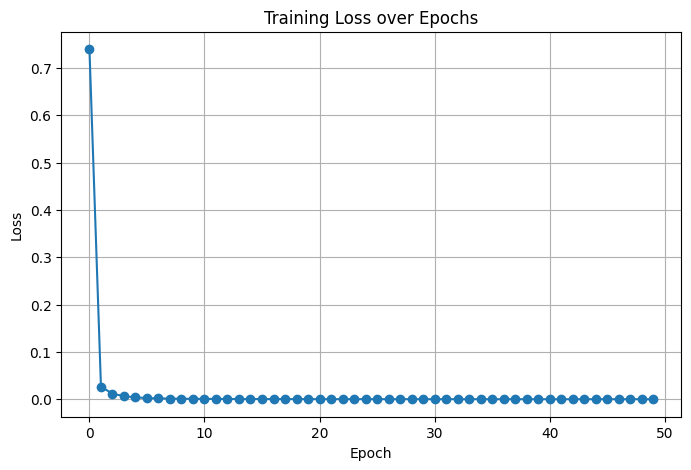

모델과 문자 집합이 저장되었습니다: /content/asr_model


In [ ]:
# 1. 의존성 로드
import os, json, torch, librosa, hgtk
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

# 2. 자모 분리 함수--한글 문자의 자음과 모음을 분리한다.
def split_jamos(text):
    result = []
    for ch in text:
        if hgtk.checker.is_hangul(ch):
            result.extend(hgtk.letter.decompose(ch))
        else:
            result.append(ch)
    return result

# 3. JSON 로드 및 samples 생성--모델 학습에 쓰일 json파일 로드 및 audio wave를 가져온다.
with open("/content/Korean_Read_Speech_Corpus_sample.json", "r") as f:
    data = json.load(f)

samples = []
for fname, meta in data["AirbnbStudio"].items():
    path = f"/content/AirbnbStudio/{fname}.wav"
    if os.path.exists(path):
        samples.append({"path": path, "text": meta["text"]})

# 4. 자모 기반 vocab 구성--한글 자음과 모음 기반하여 어휘를 구성한다.
vocab = sorted(set(j for s in samples for j in split_jamos(s["text"])))
char2idx = {c: i + 1 for i, c in enumerate(vocab)}  # 0 = padding
idx2char = {i: c for c, i in char2idx.items()}
vocab_size = len(char2idx) + 1

# 5. Dataset 정의
class AttentionASRDataset(Dataset):
    def __init__(self, sample_list, max_len=300):
        self.samples = sample_list
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        y, sr = librosa.load(sample['path'], sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T
        if mfcc.shape[0] > self.max_len:
            mfcc = mfcc[:self.max_len]
        x = torch.tensor(mfcc, dtype=torch.float32)

        jamos = split_jamos(sample['text'])
        label = [char2idx[c] for c in jamos]
        y = torch.tensor(label, dtype=torch.long)
        return x, y

# 6. Collate 함수
def collate_fn(batch):
    xs, ys = zip(*batch)
    max_x = max([x.shape[0] for x in xs])
    max_y = max([y.shape[0] for y in ys])
    padded_x = [torch.cat([x, torch.zeros(max_x - x.shape[0], x.shape[1])], dim=0) for x in xs]
    padded_y = [torch.cat([y, torch.zeros(max_y - y.shape[0], dtype=torch.long)], dim=0) for y in ys]
    return torch.stack(padded_x), torch.stack(padded_y)

# 7. 모델 정의
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)

    def forward(self, x):
        output, _ = self.lstm(x)
        return output  # [B, T, 2H]

class AttentionDecoder(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim + 2 * hidden_dim, hidden_dim, batch_first=True)
        self.attn = nn.Linear(hidden_dim + 2 * hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, enc_output, target_seq, max_len):
        B, T, H_enc = enc_output.shape  # H_enc = 256*2 = 512
        embedded = self.embedding(target_seq)  # [B, L, 256]
        outputs, hidden = [], None

        for t in range(max_len):
            query = embedded[:, t].unsqueeze(1).expand(-1, T, -1)  # [B, T, 256]
            attn_input = torch.cat([query, enc_output], dim=2)     # [B, T, 768]
            energy = self.attn(attn_input).squeeze(2)              # [B, T]
            attn_weights = torch.softmax(energy, dim=1).unsqueeze(1)  # [B, 1, T]
            context = torch.bmm(attn_weights, enc_output)          # [B, 1, 512]
            x = torch.cat([embedded[:, t:t+1, :], context], dim=2) # [B, 1, 768]
            out, hidden = self.lstm(x, hidden)                     # [B, 1, 256]
            output = self.fc(out.squeeze(1))                       # [B, vocab_size]
            outputs.append(output)

        return torch.stack(outputs, dim=1)  # [B, L, vocab_size]

# 8. 학습 준비
train_set = AttentionASRDataset(samples)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(13, 256).to(device)
decoder = AttentionDecoder(256, vocab_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

# 9. 학습 루프
import matplotlib.pyplot as plt

# 학습 손실값 저장 리스트
loss_history = []

# 학습 루프 (충분한 학습 필요)
for epoch in range(50):
    encoder.train()
    decoder.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        out_enc = encoder(x)  # [B, T, 512]
        out_dec = decoder(out_enc, y, max_len=y.size(1))  # [B, L, V]
        loss = criterion(out_dec.view(-1, vocab_size), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(loss_history, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 모델 저장 디렉토리 설정
save_dir = "/content/asr_model"
os.makedirs(save_dir, exist_ok=True)

# 모델 저장
torch.save(encoder.state_dict(), os.path.join(save_dir, "encoder.pt"))
torch.save(decoder.state_dict(), os.path.join(save_dir, "decoder.pt"))

# 문자 집합 저장 (char2idx와 idx2char)
import pickle
with open(os.path.join(save_dir, "vocab.pkl"), "wb") as f:
    pickle.dump({
        "char2idx": char2idx,
        "idx2char": idx2char
    }, f)

print(f"모델과 문자 집합이 저장되었습니다: {save_dir}")

In [ ]:
import hgtk

def greedy_decode(output_tensor):
    """ 디코더 출력 logits → 예측 문자 인덱스 → 자모 문자열 """
    pred_indices = output_tensor.argmax(2)  # [B, T]
    pred_sequences = []
    for seq in pred_indices:
        result = []
        for idx in seq:
            if idx.item() != 0:  # padding 제외
                result.append(idx2char.get(idx.item(), ""))
        pred_sequences.append(result)
    return pred_sequences

def merge_jamos(jamo_seq):
    result = ""
    i = 0
    while i < len(jamo_seq):
        try:
            cho = jamo_seq[i]
            jung = jamo_seq[i + 1]
            if i + 2 < len(jamo_seq):
                jong = jamo_seq[i + 2]
                try:
                    result += hgtk.letter.compose(cho, jung, jong)
                    i += 3
                except hgtk.exception.NotHangulException:
                    result += hgtk.letter.compose(cho, jung)
                    i += 2
            else:
                result += hgtk.letter.compose(cho, jung)
                i += 2
        except:
            result += ''.join(jamo_seq[i:])
            break
    return result

In [ ]:
def infer(file_path):
    # 1) 음성 로드 및 MFCC 추출
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T
    mfcc_tensor = torch.tensor(mfcc[:300], dtype=torch.float32).unsqueeze(0).to(device)  # [1, T, 13]

    # 2) 모델 추론
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        enc_output = encoder(mfcc_tensor)
        dummy_target = torch.zeros((1, 30), dtype=torch.long).to(device)  # 최대 추론 길이만큼 빈 타겟
        output = decoder(enc_output, dummy_target, max_len=30)

    # 3) 디코딩
    jamo_seq = greedy_decode(output)[0]
    result = merge_jamos(jamo_seq)

    print("자모:", "".join(jamo_seq))
    print("결과:", result)
    return result

In [ ]:
# 예: AirbnbStudio의 파일 중 하나
infer("/content/AirbnbStudio/sub100100a00000.wav")

자모:                               
결과:                               


'                              '